In [1]:
# ✅ 必要ライブラリ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler

# ✅ データ読み込み
PATH = '../data/'
X = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'test.csv')

# ✅ Age 欠損処理
X["Age_filled"] = X["Age"].fillna(-1)
X["Age_missing"] = X["Age"].isna().astype(int)
X = X.drop(columns=["Age"])
test["Age_filled"] = test["Age"].fillna(-1)
test["Age_missing"] = test["Age"].isna().astype(int)
test = test.drop(columns=["Age"])

# ✅ 数値カラム欠損補完
for col in X.columns:
    if X[col].isnull().sum() > 0:
        median = X[col].median()
        X[col] = X[col].fillna(median)
        test[col] = test[col].fillna(median)

# ✅ 不要カラム削除
X = X.drop(columns=["Id"])
test = test.drop(columns=["Id"])

# ✅ 目的変数分離
y = X["Drafted"]
X = X.drop(columns=["Drafted"])

# ✅ School, Player_Type, Position_Type 削除
X = X.drop(columns=["School", "Player_Type", "Position_Type"])
test = test.drop(columns=["School", "Player_Type", "Position_Type"])

# ✅ Position Target Encoding
position_stats = X.copy()
position_stats["Drafted"] = y
position_target_map = position_stats.groupby("Position")["Drafted"].mean()
X["Position_encoded"] = X["Position"].map(position_target_map)
test["Position_encoded"] = test["Position"].map(position_target_map)
test["Position_encoded"] = test["Position_encoded"].fillna(X["Position_encoded"].mean())

# ✅ Position Group Encoding (fold-safe)
def map_position_group(pos):
    if pos in ["K", "P", "LS"]:
        return "Specialist"
    elif pos in ["WR", "RB", "TE"]:
        return "OffensiveSkill"
    elif pos in ["OT", "OG", "C"]:
        return "OffensiveLine"
    elif pos in ["DE", "DT"]:
        return "DefensiveLine"
    elif pos in ["OLB", "ILB"]:
        return "Linebacker"
    elif pos in ["CB", "FS", "SS", "S", "DB"]:
        return "DefensiveBack"
    elif pos == "QB":
        return "Quarterback"
    elif pos == "FB":
        return "Fullback"
    else:
        return "Other"

X["Position_group"] = X["Position"].apply(map_position_group)
test["Position_group"] = test["Position"].apply(map_position_group)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
X["Position_group_encoded"] = 0
for train_idx, val_idx in kf.split(X):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    group_map = X_train.assign(Drafted=y_train).groupby("Position_group")["Drafted"].mean()
    X.loc[val_idx, "Position_group_encoded"] = X.loc[val_idx, "Position_group"].map(group_map)
final_group_map = X.assign(Drafted=y).groupby("Position_group")["Drafted"].mean()
test["Position_group_encoded"] = test["Position_group"].map(final_group_map)
test["Position_group_encoded"] = test["Position_group_encoded"].fillna(X["Position_group_encoded"].mean())

X = X.drop(columns=["Position", "Position_group"])
test = test.drop(columns=["Position", "Position_group"])

# ✅ SpeedScore, BurstScore, AgilityScore, ASI, RSA特徴量
X["Weight_lbs"] = X["Weight"] * 2.20462
test["Weight_lbs"] = test["Weight"] * 2.20462

X["SpeedScore"] = X["Weight_lbs"] * (200 / X["Sprint_40yd"]**2)
test["SpeedScore"] = test["Weight_lbs"] * (200 / test["Sprint_40yd"]**2)

X["BurstScore"] = X["Vertical_Jump"] + X["Broad_Jump"]
test["BurstScore"] = test["Vertical_Jump"] + test["Broad_Jump"]

X["AgilityScore"] = X["Shuttle"] + X["Agility_3cone"]
test["AgilityScore"] = test["Shuttle"] + test["Agility_3cone"]

X["ASI"] = 0.5 * X["SpeedScore"] + 0.3 * X["BurstScore"] + 0.2 * X["AgilityScore"]
test["ASI"] = 0.5 * test["SpeedScore"] + 0.3 * test["BurstScore"] + 0.2 * test["AgilityScore"]

rsa_features = ["Sprint_40yd", "Vertical_Jump", "Bench_Press_Reps", "Shuttle", "Agility_3cone"]
for col in rsa_features:
    scaler = MinMaxScaler(feature_range=(0, 10))
    if col in ["Sprint_40yd", "Shuttle", "Agility_3cone"]:
        X[f"RSA_{col}"] = 10 - scaler.fit_transform(X[[col]])
        test[f"RSA_{col}"] = 10 - scaler.transform(test[[col]])
    else:
        X[f"RSA_{col}"] = scaler.fit_transform(X[[col]])
        test[f"RSA_{col}"] = scaler.transform(test[[col]])

# ✅ BMI
X["BMI"] = X["Weight"] / (X["Height"]/100)**2
test["BMI"] = test["Weight"] / (test["Height"]/100)**2

# ✅ School特徴量（Top, Drafted Count, Drafted Rate TE）
df_raw = pd.read_csv(PATH + 'train.csv')
test_raw = pd.read_csv(PATH + 'test.csv')
X["School"] = df_raw["School"]
test["School"] = test_raw["School"]

school_stats = X.copy()
school_stats["Drafted"] = y
school_agg = school_stats.groupby("School")["Drafted"].agg(["sum", "count"])
school_agg["Drafted_Rate"] = school_agg["sum"] / school_agg["count"]

top_n = 20
top_schools = school_agg["sum"].sort_values(ascending=False).head(top_n).index.tolist()

X["School_Top"] = X["School"].isin(top_schools).astype(int)
test["School_Top"] = test["School"].isin(top_schools).astype(int)

X["School_Drafted_Count"] = X["School"].map(school_agg["sum"])
test["School_Drafted_Count"] = test["School"].map(school_agg["sum"])
test["School_Drafted_Count"] = test["School_Drafted_Count"].fillna(0)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
X["School_Drafted_Rate_TE"] = 0.0
for train_idx, val_idx in kf.split(X):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    rate_map = X_train.assign(Drafted=y_train).groupby("School")["Drafted"].mean()
    X.loc[val_idx, "School_Drafted_Rate_TE"] = X.loc[val_idx, "School"].map(rate_map)
final_rate_map = X.assign(Drafted=y).groupby("School")["Drafted"].mean()
test["School_Drafted_Rate_TE"] = test["School"].map(final_rate_map)
test["School_Drafted_Rate_TE"] = test["School_Drafted_Rate_TE"].fillna(y.mean())

X = X.drop(columns=["School"])
test = test.drop(columns=["School"])




C:\Users\81807\AppData\Local\Temp\ipykernel_7264\4287927465.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.6        0.2739726  0.65632458 0.7109375  0.62895928 0.62895928
 0.65632458 0.62895928 0.7109375  0.71884984 0.6        0.65632458
 0.65632458 0.71884984 0.62895928 0.62895928 0.65632458 0.71884984
 0.62895928 0.65632458 0.65632458 0.62895928 0.62895928 0.65632458
 0.6        0.62895928 0.62895928 0.65632458 0.71884984 0.7109375
 0.62895928 0.7109375  0.71884984 0.62895928 0.65632458 0.62895928
 0.2739726  0.65632458 0.65632458 0.2739726  0.68376068 0.65632458
 0.62895928 0.48275862 0.68376068 0.68376068 0.71884984 0.62895928
 0.62895928 0.62895928 0.7109375  0.62895928 0.71884984 0.65632458
 0.7109375  0.62895928 0.6        0.62895928 0.7109375  0.65632458
 0.62895928 0.62895928 0.71884984 0.71884984 0.68376068 0.7109375
 0.68376068 0.65632458 0.62895928 0.62895928 0.62895928 0.62895928
 0

In [2]:
X["Speed_BMI_Ratio"] = X["SpeedScore"] / X["BMI"]
test["Speed_BMI_Ratio"] = test["SpeedScore"] / test["BMI"]

X["Sprint_ASI"] = X["Sprint_40yd"] * X["ASI"]
test["Sprint_ASI"] = test["Sprint_40yd"] * test["ASI"]

X["Age_Speed"] = X["Age_filled"] * X["SpeedScore"]
test["Age_Speed"] = test["Age_filled"] * test["SpeedScore"]

[LightGBM] [Info] Number of positive: 1445, number of negative: 779
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3496
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649730 -> initscore=0.617854
[LightGBM] [Info] Start training from score 0.617854
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no

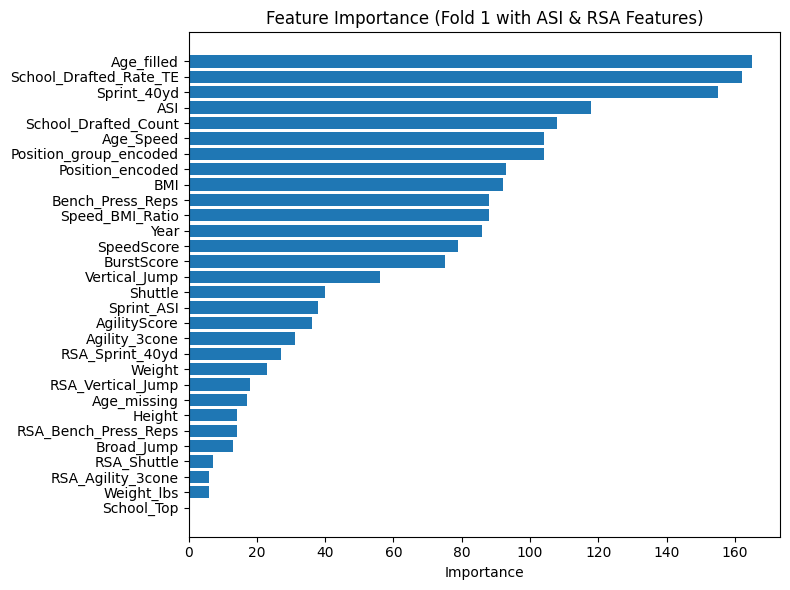

[LightGBM] [Info] Number of positive: 1448, number of negative: 777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3495
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650787 -> initscore=0.622498
[LightGBM] [Info] Start training from score 0.622498
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[169]	valid_0's auc: 0.849022	valid_0's binary_logloss: 0.425999
✅ Fold 2 - Train AUC: 0.9020, Validation AUC: 0.8490
[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000658 seconds.
You can set `force_col_wise=true` to remove the ove

In [3]:
# ✅ LightGBM 訓練
model = LGBMClassifier(
    max_depth=6,
    num_leaves=10,
    min_child_samples=38,
    reg_alpha=8.18,
    reg_lambda=8.07,
    learning_rate=0.0442,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_aucs = []
val_aucs = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='auc',
        callbacks=[
            lgb.early_stopping(stopping_rounds=30),
            lgb.log_evaluation(0)
        ]
    )

    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_valid_pred = model.predict_proba(X_valid)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)

    train_aucs.append(train_auc)
    val_aucs.append(val_auc)

    print(f"✅ Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

    if fold == 0:
        importances = model.feature_importances_
        feature_names = X.columns

        # ソート（重要度降順）
        sorted_idx = importances.argsort()
        sorted_importances = importances[sorted_idx]
        sorted_feature_names = feature_names[sorted_idx]

        plt.figure(figsize=(8, 6))
        plt.barh(sorted_feature_names, sorted_importances)
        plt.title("Feature Importance (Fold 1 with ASI & RSA Features)")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

print(f"\n✅ Average Train AUC: {np.mean(train_aucs):.4f}")
print(f"✅ Average Validation AUC: {np.mean(val_aucs):.4f}")

In [4]:
# ✅ 高相関特徴量削除
drop_cols_high_corr = [
    "Weight_lbs",
    "RSA_Sprint_40yd",
    "RSA_Vertical_Jump",
    "RSA_Bench_Press_Reps",
    "RSA_Agility_3cone",
    "RSA_Shuttle",
    "SpeedScore",
    "Age_missing"
]
X = X.drop(columns=drop_cols_high_corr)
test = test.drop(columns=drop_cols_high_corr)


[LightGBM] [Info] Number of positive: 1445, number of negative: 779
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2589
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649730 -> initscore=0.617854
[LightGBM] [Info] Start training from score 0.617854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[112]	valid_0's auc: 0.858342	valid_0's binary_logloss: 0.416497
✅ Fold 1 - Train AUC: 0.8853, Validation AUC: 0.8583


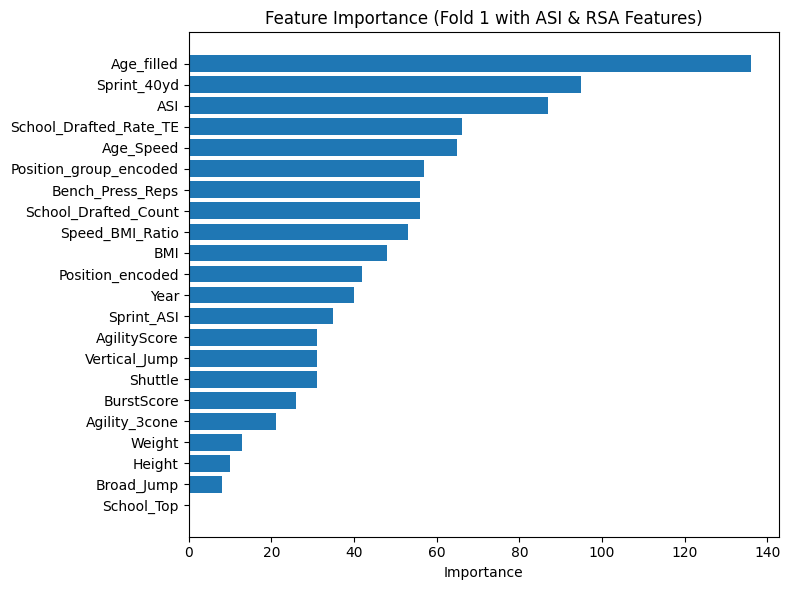

[LightGBM] [Info] Number of positive: 1448, number of negative: 777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2594
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650787 -> initscore=0.622498
[LightGBM] [Info] Start training from score 0.622498
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[75]	valid_0's auc: 0.845183	valid_0's binary_logloss: 0.438607
✅ Fold 2 - Train AUC: 0.8830, Validation AUC: 0.8452
[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2603
[LightGBM] [Info] Number of data po

In [5]:
# ✅ LightGBM 訓練
model = LGBMClassifier(
    max_depth=6,
    num_leaves=10,
    min_child_samples=38,
    reg_alpha=8.18,
    reg_lambda=8.07,
    learning_rate=0.0442,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_aucs = []
val_aucs = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='auc',
        callbacks=[
            lgb.early_stopping(stopping_rounds=30),
            lgb.log_evaluation(0)
        ]
    )

    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_valid_pred = model.predict_proba(X_valid)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)

    train_aucs.append(train_auc)
    val_aucs.append(val_auc)

    print(f"✅ Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

    if fold == 0:
        importances = model.feature_importances_
        feature_names = X.columns

        # ソート（重要度降順）
        sorted_idx = importances.argsort()
        sorted_importances = importances[sorted_idx]
        sorted_feature_names = feature_names[sorted_idx]

        plt.figure(figsize=(8, 6))
        plt.barh(sorted_feature_names, sorted_importances)
        plt.title("Feature Importance (Fold 1 with ASI & RSA Features)")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

print(f"\n✅ Average Train AUC: {np.mean(train_aucs):.4f}")
print(f"✅ Average Validation AUC: {np.mean(val_aucs):.4f}")

In [6]:
# ✅ CatBoost 訓練・AUC計測（単独セル）

from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

model_cat = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=5.0,
    eval_metric='AUC',
    random_seed=42,
    early_stopping_rounds=30,
    verbose=False
)

train_aucs_cat = []
val_aucs_cat = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model_cat.fit(
        X_train, y_train,
        eval_set=(X_valid, y_valid),
        use_best_model=True
    )

    y_train_pred = model_cat.predict_proba(X_train)[:, 1]
    y_valid_pred = model_cat.predict_proba(X_valid)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)

    train_aucs_cat.append(train_auc)
    val_aucs_cat.append(val_auc)

    print(f"✅ [CatBoost] Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

print(f"\n✅ [CatBoost] Average Train AUC: {np.mean(train_aucs_cat):.4f}")
print(f"✅ [CatBoost] Average Validation AUC: {np.mean(val_aucs_cat):.4f}")


✅ [CatBoost] Fold 1 - Train AUC: 0.9579, Validation AUC: 0.8717
✅ [CatBoost] Fold 2 - Train AUC: 0.9063, Validation AUC: 0.8572
✅ [CatBoost] Fold 3 - Train AUC: 0.9348, Validation AUC: 0.8360
✅ [CatBoost] Fold 4 - Train AUC: 0.8744, Validation AUC: 0.8074
✅ [CatBoost] Fold 5 - Train AUC: 0.9243, Validation AUC: 0.8615

✅ [CatBoost] Average Train AUC: 0.9195
✅ [CatBoost] Average Validation AUC: 0.8468


In [7]:
# ✅ XGBoost 訓練・AUC計測（単独セル）

from xgboost import XGBClassifier

kf = KFold(n_splits=5, shuffle=True, random_state=42)

model_xgb = XGBClassifier(
    n_estimators=2000,
    max_depth=3,
    learning_rate=0.015,
    reg_alpha=15.0,
    reg_lambda=15.0,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42,
    eval_metric='auc'
)


train_aucs_xgb = []
val_aucs_xgb = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model_xgb.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False
    )

    y_train_pred = model_xgb.predict_proba(X_train)[:, 1]
    y_valid_pred = model_xgb.predict_proba(X_valid)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)

    train_aucs_xgb.append(train_auc)
    val_aucs_xgb.append(val_auc)

    print(f"✅ [XGBoost] Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

print(f"\n✅ [XGBoost] Average Train AUC: {np.mean(train_aucs_xgb):.4f}")
print(f"✅ [XGBoost] Average Validation AUC: {np.mean(val_aucs_xgb):.4f}")


✅ [XGBoost] Fold 1 - Train AUC: 0.8800, Validation AUC: 0.8625
✅ [XGBoost] Fold 2 - Train AUC: 0.8844, Validation AUC: 0.8498
✅ [XGBoost] Fold 3 - Train AUC: 0.8885, Validation AUC: 0.8171
✅ [XGBoost] Fold 4 - Train AUC: 0.8857, Validation AUC: 0.8061
✅ [XGBoost] Fold 5 - Train AUC: 0.8794, Validation AUC: 0.8562

✅ [XGBoost] Average Train AUC: 0.8836
✅ [XGBoost] Average Validation AUC: 0.8383


In [8]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# LightGBM モデル
from lightgbm import LGBMClassifier
model_lgb = LGBMClassifier(
    max_depth=6,
    num_leaves=10,
    min_child_samples=38,
    reg_alpha=8.18,
    reg_lambda=8.07,
    learning_rate=0.0442,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# CatBoost モデル
from catboost import CatBoostClassifier
model_cat = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=5.0,
    eval_metric='AUC',
    random_seed=42,
    verbose=False
)

# XGBoost モデル（過学習抑制済バージョン）
from xgboost import XGBClassifier
model_xgb = XGBClassifier(
    n_estimators=2000,
    max_depth=3,
    learning_rate=0.015,
    reg_alpha=15.0,
    reg_lambda=15.0,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42,
    eval_metric='auc'
)

# VotingClassifier 設定（soft voting で確率平均）
voting_clf = VotingClassifier(
    estimators=[
        ('lgb', model_lgb),
        ('cat', model_cat),
        ('xgb', model_xgb)
    ],
    voting='soft',
    n_jobs=-1
)

# Cross-Validation で AUC を確認
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = cross_val_score(
    voting_clf, X, y,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1
)

print(f"\n✅ [VotingClassifier] Average Validation AUC: {auc_scores.mean():.5f}")
print(f"✅ Fold-wise AUCs: {auc_scores}")



✅ [VotingClassifier] Average Validation AUC: 0.84595
✅ Fold-wise AUCs: [0.82756233 0.8759571  0.85398111 0.82070578 0.85155896]


In [9]:
# 🔄 提出用ファイルの作成処理（LightGBMモデルに基づく予測）

# original_test を再読み込みして Id を復元
original_test = pd.read_csv(PATH + "test.csv")

# 提出用特徴量列は X.columns で確定させる
feature_cols = X.columns.tolist()

# 列順を揃える
X_test = test[feature_cols]


# LightGBMモデルで予測（Drafted=1 の確率）
y_pred = model.predict_proba(X_test)[:, 1]

# 提出用DataFrameを作成
submission = pd.DataFrame({
    "Id": original_test["Id"],
    "Drafted": y_pred  
})

import os

# 保存ディレクトリをプロジェクトルートに作成
root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
save_dir = os.path.join(root_dir, "submissions")
os.makedirs(save_dir, exist_ok=True)

import os
import datetime
import re  # ← これを忘れずに！

try:
    import ipynbname
    notebook_path = ipynbname.path()
    notebook_name = notebook_path.stem  # ファイル名（拡張子なし）
except:
    notebook_name = "19_0705_notebook()"   # fallback

# 数字とアンダースコア部分だけ抽出（例：06_0627）
match = re.search(r"\d{2}_\d{4}", notebook_name)
tag = match.group() if match else notebook_name

filename = f"submission_{tag}.csv"


# 提出ファイル名を組み立てる
filename = f"submission_{tag}.csv"
save_path = os.path.join(save_dir, filename)

# 書き出し
submission.to_csv(save_path, index=False)
print(f"✅ 提出ファイルを保存しました: {save_path}")

✅ 提出ファイルを保存しました: c:\Users\81807\Desktop\Kaggle\GCI②(NFL Draft Prediction)\submissions\submission_19_0705.csv
